# Identifying Pneumonia with Deep Learning
***
Author: Andre Layton
***

# Overview
.......

# Business Problem
........

***
<img src="https://media.licdn.com/dms/image/D4D12AQEqfniioS4KVQ/article-cover_image-shrink_720_1280/0/1677311223167?e=2147483647&v=beta&t=loMCjRjjqYyKI72mjdbVk5_XbxRdzonIKz0qRn-BcXo" style="height:500px; width:875px" />

## Data Understanding

In [1]:
# Import all the necessary libraries
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers import scikit_learn
import os

In [2]:
# Create directory path objects
train_data_dir = 'data/chest_xray/train'
test_data_dir = 'data/chest_xray/test'
validation_dir = 'data/chest_xray/val'

# Gather and reshape the data in each directory object
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir, target_size=(64, 64), batch_size=5216,
                                                           seed=24)
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(64, 64), batch_size=624,
                                                           seed=24)
val_generator = ImageDataGenerator().flow_from_directory(validation_dir, target_size=(64, 64), batch_size=16,
                                                           seed=24)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


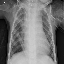

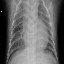

In [3]:
# Preview some images
display(array_to_img(train_images[17]))
array_to_img(train_images[4200])

In [4]:
# Preview the shape of the data
print("Train Data Shape:")
print(np.shape(train_images))
print(np.shape(train_labels))
print("\nTest Data Shape:")
print(np.shape(test_images))
print(np.shape(test_labels))
print("\nValidation Data Shape:")
print(np.shape(val_images))
print(np.shape(val_labels))

Train Data Shape:
(5216, 64, 64, 3)
(5216, 2)

Test Data Shape:
(624, 64, 64, 3)
(624, 2)

Validation Data Shape:
(16, 64, 64, 3)
(16, 2)


In [ ]:
# Reshape the train, test, and validation images 
#train_img_unrow = train_images.reshape(5216, -1).T
#test_img_unrow = test_images.reshape(624, -1).T
#val_img_unrow = val_images.reshape(16, -1).T

# Preview the shape of each newly-formed objects
#print(np.shape(train_img_unrow))
#print(np.shape(test_img_unrow))
#print(np.shape(val_img_unrow))

In [5]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [6]:
# Reshape the label datasets, and select the 'PNEUMONIA' column
y_train_labels = train_labels.T[[1]]
y_test_labels = test_labels.T[[1]]
y_val_labels = val_labels.T[[1]]

# Check the shape of the transformed labels 
print(np.shape(y_train_labels))
print(np.shape(y_test_labels))
print(np.shape(y_val_labels))

(1, 5216)
(1, 624)
(1, 16)


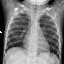

[0.]


In [7]:
# Confirm if the image matches the corresponding label
display(array_to_img(train_images[1400]))
print(y_train_labels[:, 1400])

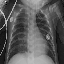

[1.]


In [8]:
# Confirm if the image matches the corresponding label
display(array_to_img(train_images[14]))
print(y_train_labels[:, 14])

## Modeling

### Baseline Model:

In [9]:
# Reshape the train, test, and validation images for modeling
X_train = train_images.reshape(5216, -1)
X_test = test_images.reshape(624, -1)
X_val = val_images.reshape(16, -1)

# Preview the shape of each newly-formed objects
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(X_val))

(5216, 12288)
(624, 12288)
(16, 12288)


In [10]:
# Standardize the datasets
X_train_final = X_train/255
X_test_final = X_test/255
X_val_final = X_val/255

In [11]:
# Reshape the label datasets for modeling
y_train = np.reshape(train_labels[:, 0], (5216, 1))
y_test = np.reshape(test_labels[:, 0], (624, 1))
y_val = np.reshape(val_labels[:, 0], (16, 1))

# Check the shape of the transformed labels 
print(np.shape(y_train))
print(np.shape(y_test))
print(np.shape(y_val))

(5216, 1)
(624, 1)
(16, 1)


In [12]:
baseline_model = Sequential()
baseline_model.add(Dense(42, activation='relu', input_shape=(12288, )))
baseline_model.add(Dense(1, activation='sigmoid'))

In [13]:
baseline_model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['acc'])

In [14]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 42)                516138    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 43        
Total params: 516,181
Trainable params: 516,181
Non-trainable params: 0
_________________________________________________________________


In [15]:
baseline = baseline_model.fit(X_train_final, y_train, epochs=75, batch_size=320,
                                      validation_data=(X_val_final, y_val))

Epoch 1/75
17/17 [==============================] - 1s 39ms/step - loss: 3.6253 - acc: 0.6210 - val_loss: 7.6388 - val_acc: 0.5000
Epoch 2/75
17/17 [==============================] - 0s 21ms/step - loss: 1.3971 - acc: 0.7168 - val_loss: 0.9004 - val_acc: 0.6250
Epoch 3/75
17/17 [==============================] - 0s 21ms/step - loss: 1.2400 - acc: 0.7046 - val_loss: 0.8498 - val_acc: 0.6875
Epoch 4/75
17/17 [==============================] - 0s 21ms/step - loss: 0.8775 - acc: 0.7742 - val_loss: 0.5429 - val_acc: 0.7500
Epoch 5/75
17/17 [==============================] - 0s 20ms/step - loss: 0.8861 - acc: 0.7586 - val_loss: 0.9711 - val_acc: 0.6250
Epoch 6/75
17/17 [==============================] - 0s 29ms/step - loss: 0.7631 - acc: 0.8108 - val_loss: 3.5772 - val_acc: 0.5000
Epoch 7/75
17/17 [==============================] - 1s 42ms/step - loss: 0.8258 - acc: 0.7910 - val_loss: 0.6028 - val_acc: 0.7500
Epoch 8/75
17/17 [==============================] - 1s 38ms/step - loss: 0.6550 - a

Epoch 63/75
17/17 [==============================] - 1s 50ms/step - loss: 0.1881 - acc: 0.9241 - val_loss: 0.2618 - val_acc: 0.8125
Epoch 64/75
17/17 [==============================] - 1s 45ms/step - loss: 0.1928 - acc: 0.9201 - val_loss: 0.4177 - val_acc: 0.8125
Epoch 65/75
17/17 [==============================] - 1s 44ms/step - loss: 0.1794 - acc: 0.9294 - val_loss: 0.5555 - val_acc: 0.7500
Epoch 66/75
17/17 [==============================] - 1s 48ms/step - loss: 0.1821 - acc: 0.9260 - val_loss: 0.2612 - val_acc: 0.9375
Epoch 67/75
17/17 [==============================] - 1s 45ms/step - loss: 0.1643 - acc: 0.9314 - val_loss: 0.2340 - val_acc: 0.9375
Epoch 68/75
17/17 [==============================] - 1s 47ms/step - loss: 0.1726 - acc: 0.9354 - val_loss: 0.7217 - val_acc: 0.7500
Epoch 69/75
17/17 [==============================] - 1s 53ms/step - loss: 0.1772 - acc: 0.9281 - val_loss: 0.3776 - val_acc: 0.8750
Epoch 70/75
17/17 [==============================] - 1s 61ms/step - loss: 0.

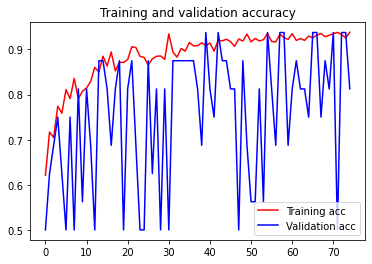

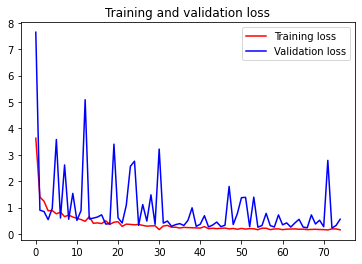

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = baseline.history['acc']
val_acc = baseline.history['val_acc']
loss = baseline.history['loss']
val_loss = baseline.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Cross-Validating the Baseline Model:

In [17]:
def build_model():
    model = Sequential()
    model.add(Dense(42, activation='relu', input_shape=(12288, )))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy', 
                  optimizer='RMSprop', 
                  metrics=['acc'])
    return model

In [19]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=45,
                                          batch_size=320,
                                          verbose=2)
validation_scores = cross_val_score(keras_model, X_train_final, y_train)

Epoch 1/45
14/14 - 0s - loss: 4.0307 - acc: 0.6194
Epoch 2/45
14/14 - 0s - loss: 0.5308 - acc: 0.7512
Epoch 3/45
14/14 - 0s - loss: 0.4798 - acc: 0.7452
Epoch 4/45
14/14 - 0s - loss: 0.4576 - acc: 0.7570
Epoch 5/45
14/14 - 0s - loss: 0.4114 - acc: 0.7543
Epoch 6/45
14/14 - 0s - loss: 0.3910 - acc: 0.8217
Epoch 7/45
14/14 - 0s - loss: 0.3664 - acc: 0.8492
Epoch 8/45
14/14 - 0s - loss: 0.3613 - acc: 0.8476
Epoch 9/45
14/14 - 0s - loss: 0.3511 - acc: 0.8591
Epoch 10/45
14/14 - 0s - loss: 0.3402 - acc: 0.8691
Epoch 11/45
14/14 - 0s - loss: 0.3295 - acc: 0.8794
Epoch 12/45
14/14 - 0s - loss: 0.3221 - acc: 0.8893
Epoch 13/45
14/14 - 0s - loss: 0.3128 - acc: 0.8936
Epoch 14/45
14/14 - 0s - loss: 0.3077 - acc: 0.8981
Epoch 15/45
14/14 - 0s - loss: 0.3054 - acc: 0.8984
Epoch 16/45
14/14 - 0s - loss: 0.2980 - acc: 0.9036
Epoch 17/45
14/14 - 0s - loss: 0.2883 - acc: 0.9080
Epoch 18/45
14/14 - 0s - loss: 0.2892 - acc: 0.9092
Epoch 19/45
14/14 - 0s - loss: 0.2814 - acc: 0.9132
Epoch 20/45
14/14 - 0

14/14 - 0s - loss: 0.4565 - acc: 0.8524
Epoch 23/45
14/14 - 0s - loss: 0.4528 - acc: 0.8553
Epoch 24/45
14/14 - 0s - loss: 0.4171 - acc: 0.8855
Epoch 25/45
14/14 - 0s - loss: 0.5173 - acc: 0.8373
Epoch 26/45
14/14 - 0s - loss: 0.3400 - acc: 0.8922
Epoch 27/45
14/14 - 0s - loss: 0.4097 - acc: 0.8792
Epoch 28/45
14/14 - 0s - loss: 0.4588 - acc: 0.8725
Epoch 29/45
14/14 - 0s - loss: 0.4329 - acc: 0.8622
Epoch 30/45
14/14 - 0s - loss: 0.2958 - acc: 0.8943
Epoch 31/45
14/14 - 0s - loss: 0.3945 - acc: 0.8787
Epoch 32/45
14/14 - 0s - loss: 0.3941 - acc: 0.8756
Epoch 33/45
14/14 - 0s - loss: 0.3898 - acc: 0.8795
Epoch 34/45
14/14 - 0s - loss: 0.3850 - acc: 0.8684
Epoch 35/45
14/14 - 0s - loss: 0.2919 - acc: 0.8965
Epoch 36/45
14/14 - 0s - loss: 0.3712 - acc: 0.8953
Epoch 37/45
14/14 - 0s - loss: 0.3522 - acc: 0.8744
Epoch 38/45
14/14 - 0s - loss: 0.1424 - acc: 0.9451
Epoch 39/45
14/14 - 0s - loss: 0.3971 - acc: 0.8948
Epoch 40/45
14/14 - 0s - loss: 0.2834 - acc: 0.9152
Epoch 41/45
14/14 - 0s -

In [20]:
validation_scores.mean()

0.8686553001403808

### Convolutional Network: